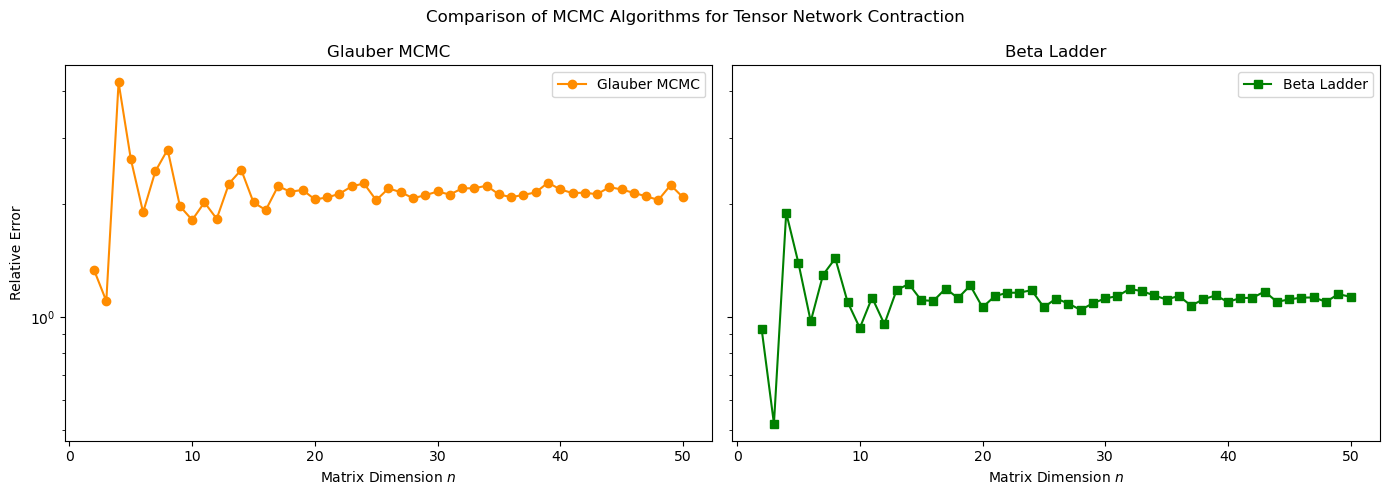

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# tensor network class, builds graph structure + index maps
class TensorNetwork:
    def __init__(self, graph, tensors):
        self.graph = graph
        self.tensors = tensors
        self.index_dims = {}
        self.index_to_tensors = {}
        for name, (tensor, indices) in tensors.items():
            for idx, dim in zip(indices, tensor.shape):
                if idx in self.index_dims:
                    assert self.index_dims[idx] == dim
                else:
                    self.index_dims[idx] = dim
                self.index_to_tensors.setdefault(idx, []).append((name, tensor, indices))

# does a single Glauber-style update to one index
def update_edge(network, config, idx):
    tensors = network.index_to_tensors[idx]
    dim = network.index_dims[idx]
    probs = np.ones(dim)
    for name, arr, inds in tensors:
        slc = [config[i] if i != idx else slice(None) for i in inds]
        probs *= arr[tuple(slc)]
    probs = probs / probs.sum() if probs.sum() > 0 else np.ones(dim) / dim
    config[idx] = np.random.choice(dim, p=probs)

# evaluates product over all tensors for the given index assignment
def evaluate_config(network, config):
    result = 1.0
    for name, (tensor, inds) in network.tensors.items():
        key = tuple(config[i] for i in inds)
        result *= tensor[key]
    return result

# basic Glauber MCMC estimator (burn-in, then average)
def estimate_contraction_glauber(network, iters=10000, burn_in=1000):
    config = {idx: np.random.randint(dim) for idx, dim in network.index_dims.items()}
    values = []
    for t in range(iters):
        idx = np.random.choice(list(network.index_dims.keys()))
        update_edge(network, config, idx)
        if t >= burn_in:
            values.append(evaluate_config(network, config))
    values = np.array(values)
    return values.mean()

# beta ladder annealed importance sampling
def estimate_contraction_beta_ladder(network, betas, iters=10000, burn_in=1000):
    config = {idx: np.random.randint(dim) for idx, dim in network.index_dims.items()}
    logZ = 0.0
    for i in range(1, len(betas)):
        beta_prev, beta_curr = betas[i - 1], betas[i]
        delta_beta = beta_curr - beta_prev
        weights = []
        for t in range(iters):
            idx = np.random.choice(list(network.index_dims.keys()))
            update_edge(network, config, idx)
            if t >= burn_in:
                w = evaluate_config(network, config)
                if w > 0:
                    weights.append(w ** (-delta_beta))
        weights = np.array(weights)
        logZ += -np.log(np.mean(weights))
    total_configurations = np.prod([dim for dim in network.index_dims.values()])
    return np.exp(logZ) * total_configurations  # rescale by |Ω|

# generates 4-node ring for Tr(ABCD)
def generate_ring_network(dim):
    G = nx.Graph()
    G.add_edges_from([('A', 'B'), ('B', 'C'), ('C', 'D'), ('D', 'A')])
    A = np.random.rand(dim, dim)
    B = np.random.rand(dim, dim)
    C = np.random.rand(dim, dim)
    D = np.random.rand(dim, dim)
    tensors = {
        'A': (A, ['i', 'j']),
        'B': (B, ['j', 'k']),
        'C': (C, ['k', 'l']),
        'D': (D, ['l', 'i'])
    }
    return TensorNetwork(G, tensors), np.trace(A @ B @ C @ D)

# ---- Experiment loop ----
dims = list(range(2, 51))  # vary tensor size D
glauber_errors = []
ais_errors = []

for D in dims:
    tn, exact = generate_ring_network(D)
    est_glauber = estimate_contraction_glauber(tn, iters=5000, burn_in=1000) * (D**4)  # rescale for full support
    est_ais = estimate_contraction_beta_ladder(tn, betas=np.linspace(0, 1, 30), iters=5000, burn_in=1000)
    glauber_errors.append(abs(est_glauber - exact) / abs(exact))  # rel error
    ais_errors.append(abs(est_ais - exact) / abs(exact))

# ---- Plot ----
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Glauber plot
axs[0].plot(dims, glauber_errors, 'o-', color='darkorange', label='Glauber MCMC')
axs[0].set_yscale('log')
axs[0].set_xlabel('Matrix Dimension $n$')
axs[0].set_ylabel('Relative Error')
axs[0].set_title('Glauber MCMC')
axs[0].legend()

# AIS plot
axs[1].plot(dims, ais_errors, 's-', color='green', label='Beta Ladder')
axs[1].set_yscale('log')
axs[1].set_xlabel('Matrix Dimension $n$')
axs[1].set_title('Beta Ladder')
axs[1].legend()

plt.suptitle('Comparison of MCMC Algorithms for Tensor Network Contraction')
plt.tight_layout()
plt.show()